In [40]:
import pandas as pd
import altair as alt
from vega_datasets import data as vega_data

# Load the data
df = pd.read_csv("../data/data_science_job_posts_2025_clean.csv", low_memory=False)

alt.data_transformers.disable_max_rows()
alt.renderers.enable('svg')

RendererRegistry.enable('svg')

# Linked spatial Visualization 1 - Top Skill by state x Top 15 skills x Salary Distribution

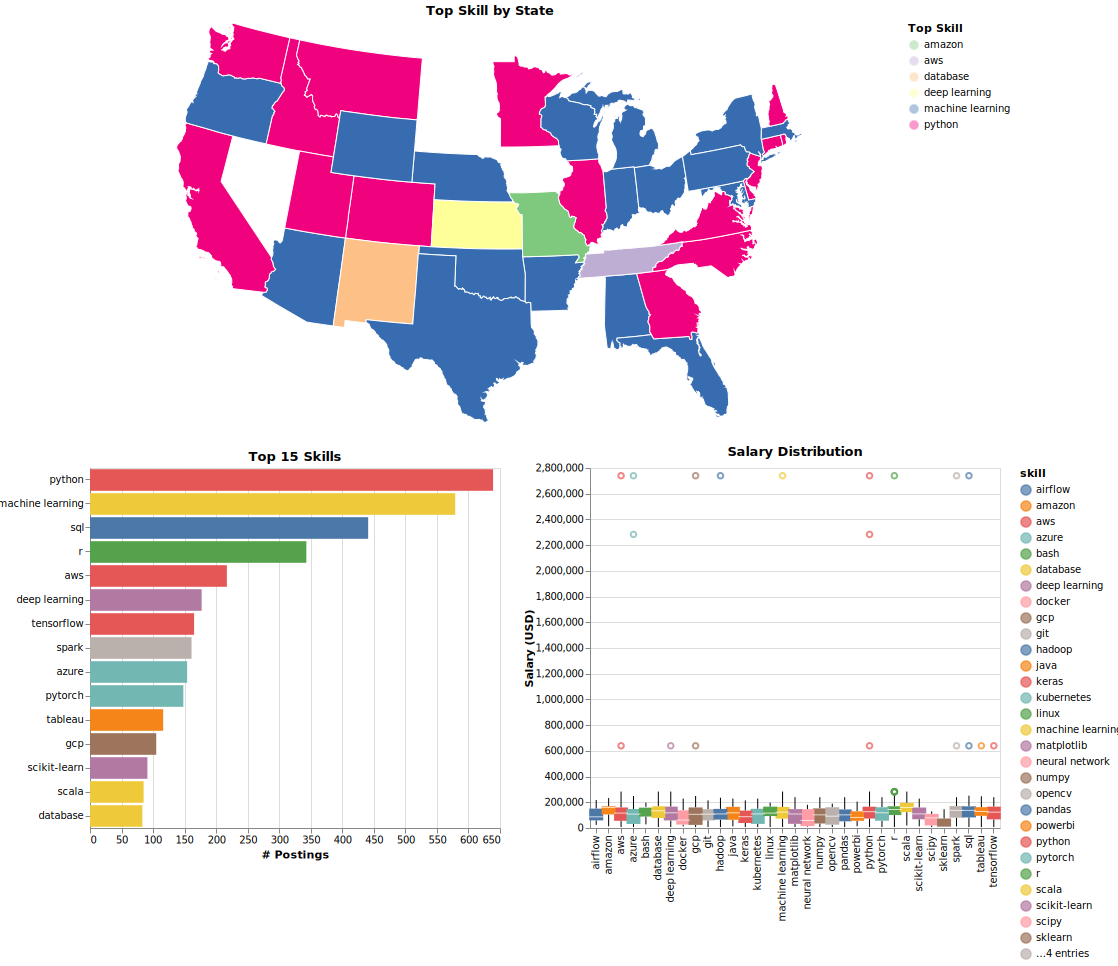

In [41]:
# explode skills
df = df.assign(skill=df["skills_clean"].fillna("").str.split("|")).explode("skill")

# # drop blank or 'null'-like skills
bad = ["", "null", "none", "na", "n/a", "nan"]
df = df[~df["skill"].str.lower().isin(bad)]

# Top skill per state (and drop zero-posting states)
state_top = (
    df.groupby(["state", "fips_int", "skill"], as_index=False)
      .size()
      .rename(columns={"size": "num_postings"})
      .query("num_postings > 0")
      .sort_values(["state", "num_postings"], ascending=[True, False])
      .drop_duplicates(subset=["state"])
)

# Selections
skill_sel = alt.selection_point(fields=["skill"], name="SkillSelect", clear="true")
state_sel = alt.selection_point(fields=["state"], name="StateSelect", clear="true")

# Map (only states with postings)
us = alt.topo_feature(vega_data.us_10m.url, "states")

base = (
    alt.Chart(us)
      .mark_geoshape(stroke="white")
      .transform_lookup(
          lookup="id",
          from_=alt.LookupData(state_top, key="fips_int", fields=["state", "skill", "num_postings"]),
      )
      .transform_filter("isValid(datum.num_postings)")
      .encode(
          color=alt.Color("skill:N", title="Top Skill", scale=alt.Scale(scheme="accent")),
          opacity=alt.value(0.4),
          tooltip=["state:N", "skill:N", "num_postings:Q"],
      )
      .project("albersUsa")
)

state_highlight = base.transform_filter(state_sel).encode(opacity=alt.value(1))
skill_highlight = base.transform_filter(skill_sel).encode(opacity=alt.value(1))

map_chart = (
    (base + skill_highlight + state_highlight)
      .add_params(state_sel)
      .properties(title="Top Skill by State", width=800, height=400)
)

# Bar (filtered by state)
bar = (
    alt.Chart(df, title="Top 15 Skills")
      .transform_filter(state_sel)
      .transform_aggregate(num_postings="count()", groupby=["skill"])
      .transform_window(
          rank="rank(num_postings)",
          sort=[{"field": "num_postings", "order": "descending"}],
      )
      .transform_filter("datum.rank <= 15")
      .mark_bar()
      .encode(
          y=alt.Y("skill:N", sort="-x", title=None),
          x=alt.X("num_postings:Q", title="# Postings"),
          color=alt.condition(skill_sel, "skill:N", alt.value("lightgray")),
          tooltip=["skill:N", "num_postings:Q"],
      )
      .add_params(skill_sel)
      .properties(width=410, height=360)
)

# Box (filtered by both)
box = (
    alt.Chart(df, title="Salary Distribution")
      .transform_filter(state_sel)
      .transform_filter(skill_sel)
      .transform_filter("isValid(datum.salary_mid)")
      .mark_boxplot()
      .encode(
          x=alt.X("skill:N", title=None),
          y=alt.Y("salary_mid:Q", title="Salary (USD)"),
          color="skill:N",
          tooltip=["state:N", "skill:N", "salary_mid:Q"],
      )
      .properties(width=410, height=360)
)

# Final layout
final_chart = alt.vconcat(map_chart, alt.hconcat(bar, box)).resolve_scale(color="independent")
final_chart


# Linked spatial Visualization 2 - Median salary by state x Top Indiustries x Skill vs Industry

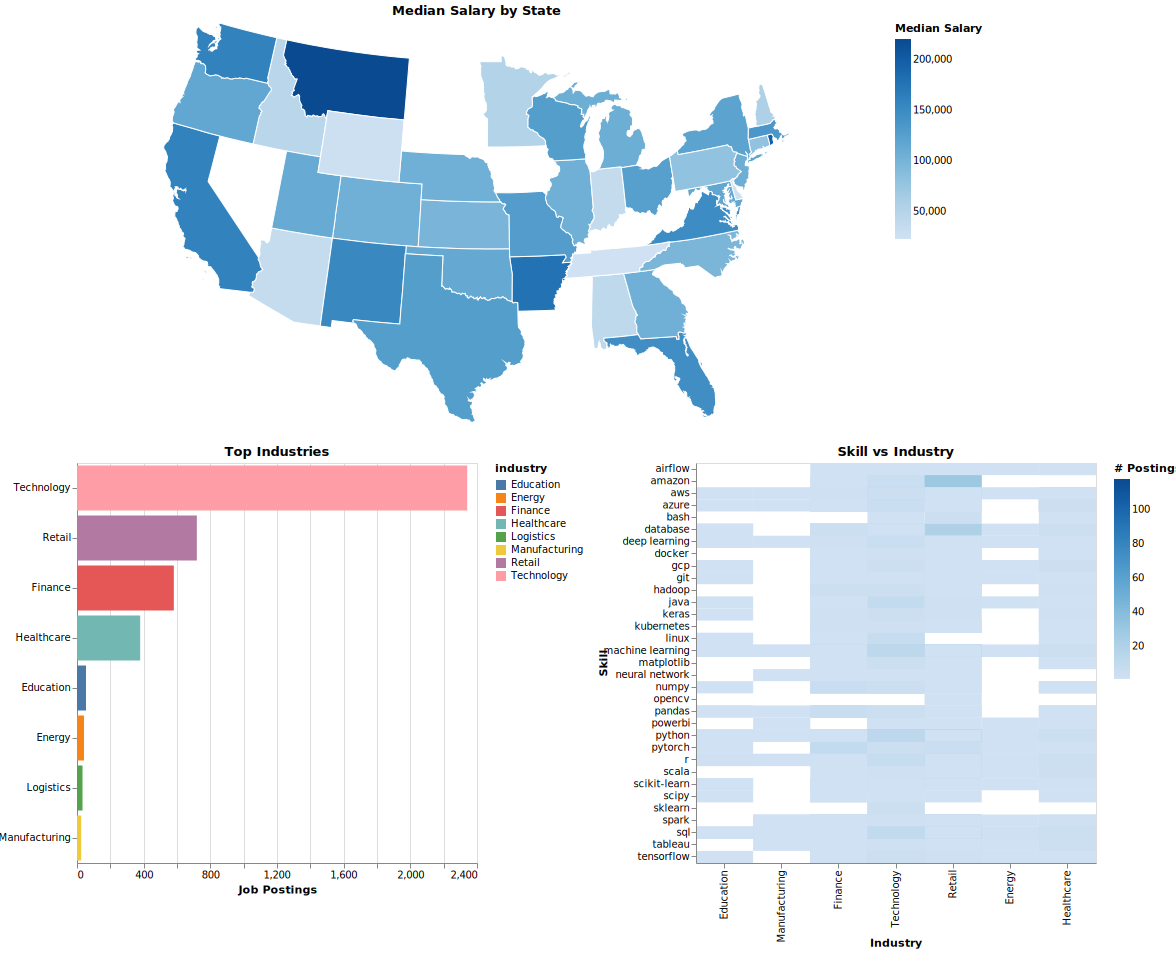

In [42]:
# aggregate - median salary + job count per state
state_agg = (
    df.groupby(["state", "fips_int"], as_index=False)
      .agg(median_salary=("salary_mid", "median"),
           n_jobs=("state", "size"))
)

skill_industry = (
    long.groupby(["state", "industry", "skill"], as_index=False)
        .size()
        .rename(columns={"size": "num_postings"})
)

# selections
state_select = alt.selection_point(fields=["state"], name="StateSelect", clear="true")
industry_select = alt.selection_point(fields=["industry"], name="IndustrySelect", clear="true")

# View A: map
us_states = alt.topo_feature(vega_data.us_10m.url, "states")
map_chart = (
    alt.Chart(us_states, title="Median Salary by State")
      .mark_geoshape(stroke="white")
      .transform_lookup(
          lookup="id",
          from_=alt.LookupData(state_agg, key="fips_int", fields=["state", "median_salary", "n_jobs"])
      )
      .transform_filter("isValid(datum.state)")
      .encode(
          color=alt.Color("median_salary:Q", title="Median Salary",scale=alt.Scale(scheme="blues")),
          tooltip=["state:N", "median_salary:Q", "n_jobs:Q"]
      )
      .add_params(state_select)
      .project("albersUsa")
      .properties(width=800, height=400)
)

# View B: industries in selected state
industries = (
    alt.Chart(df, title="Top Industries")
      .transform_filter(state_select)
      .mark_bar()
      .encode(
          x=alt.X("count():Q", title="Job Postings"),
          y=alt.Y("industry:N", sort="-x", title=None),
          color=alt.condition(industry_select, "industry:N", alt.value("lightgray")),
          tooltip=["industry:N", alt.Tooltip("count():Q", title="# Jobs")]
      )
      .add_params(industry_select)
      .properties(width=400, height=400)
)

# View C: skill vs industry, linked to both
heatmap = (
    alt.Chart(skill_industry, title="Skill vs Industry")
      .transform_filter(state_select)
      .transform_filter(industry_select)
      .mark_rect()
      .encode(
          x=alt.X("industry:N", title="Industry", sort="-y"),
          y=alt.Y("skill:N", title="Skill"),
          color=alt.Color("num_postings:Q", title="# Postings",
                          scale=alt.Scale(scheme="blues")),
          tooltip=["state:N", "industry:N", "skill:N", "num_postings:Q"]
      )
      .properties(width=400, height=400)
)

final_chart = alt.vconcat(map_chart, alt.hconcat(industries, heatmap)).resolve_scale(color="independent")
final_chart